In [1]:
#@title Imports
%reset -f
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product as cartesian_prod
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn import cluster, mixture
import zipfile
import shutil
import urllib.request
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid
from scipy.io import arff


np.set_printoptions(precision=4)


#@title Importing Packages
import os
import random
import pandas as pd

import torchvision
import torchvision.transforms as transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:

model_type = "Classification"
num_hidden_layers=3
output_dim=1
num_hidden_nodes=[500,500,500]
beta=3 
no_of_batches=1 #[1,10,100]
modep='pwc' 
optimizer_name ='Adam'
# freeze = False #True - when freeze weights of all nodes except one. False- when all nodes weights are varying
NPF_freeze = False #Default False, set True - when freeze the whole NPF
NPV_freeze = False #Default False, set True - when freeze the whole NPV
# NPF_pretrained_freezed = False #Default False, set True - when freeze the whole NPF after training it to max and NPV is trained from reinit
# NPV_pretrained_freezed = False #Default False, set True - when freeze the whole NPV after training it to max and NPF is trained from reinit
# test_on_train_data = False #Default False, set True when generate node hyperplanes on training data

input_dim=500
seeds=[365]
num_epoch=500
lr=0.001
weight_decay=0.0
threshold = 0.01 #data seperation distance

max_no_of_nodes=max(num_hidden_nodes)

num_levels=3
num_data=100000

**Data**

In [4]:
#@title Synthetic data
def set_npseed(seed):
    np.random.seed(seed)


def set_torchseed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#classification data

def data_gen_decision_tree(num_data=1000, dim=2, seed=0, w_list=None, b_list=None,vals=None, num_levels=2):        
    set_npseed(seed=seed)

    # Construct a complete decision tree with 2**num_levels-1 internal nodes,
    # e.g. num_levels=2 means there are 3 internal nodes.
    # w_list, b_list is a list of size equal to num_internal_nodes
    # vals is a list of size equal to num_leaf_nodes, with values +1 or 0
    num_internal_nodes = 2**num_levels - 1
    num_leaf_nodes = 2**num_levels
    stats = np.zeros(num_internal_nodes+num_leaf_nodes) #stores the num of datapoints at each node so at 0(root) all data points will be present

    if vals is None: #when val i.e., labels are not provided make the labels dynamically
        vals = np.arange(0,num_internal_nodes+num_leaf_nodes,1,dtype=np.int32)%2 #assign 0 or 1 label to the node based on whether its numbering is even or odd
        vals[:num_internal_nodes] = -99 #we put -99 to the internal nodes as only the values of leaf nodes are counted

    if w_list is None: #if the w values of the nodes (hyperplane eqn) are not provided then generate dynamically
        w_list = np.random.standard_normal((num_internal_nodes, dim))
        w_list = w_list/np.linalg.norm(w_list, axis=1)[:, None] #unit norm w vects
        b_list = np.zeros((num_internal_nodes))

    '''
    np.random.random_sample
    ========================
    Return random floats in the half-open interval [0.0, 1.0).

    Results are from the "continuous uniform" distribution over the
    stated interval.  To sample :math:`Unif[a, b), b > a` multiply
    the output of `random_sample` by `(b-a)` and add `a`::

        (b - a) * random_sample() + a
    '''

    data_x = np.random.random_sample((num_data, dim))*2 - 1. #generate the datas in range -1 to +1
    relevant_stats = data_x @ w_list.T + b_list #stores the x.wT+b value of each nodes for all data points(num_data x num_nodes) to check if > 0 i.e will follow right sub tree route or <0 and will follow left sub tree route
    curr_index = np.zeros(shape=(num_data), dtype=int) #stores the curr index for each data point from root to leaf. So initially a datapoint starts from root but then it can go to right or left if it goes to right its curr index will become 2 from 0 else 1 from 0 then in next iteration from say 2 it goes to right then it will become 6

    for level in range(num_levels):
        nodes_curr_level=list(range(2**level - 1,2**(level+1)-1  ))
        for el in nodes_curr_level:
            b_list[el]=-1*np.median(relevant_stats[curr_index==el,el])
            relevant_stats[:,el] += b_list[el]
        decision_variable = np.choose(curr_index, relevant_stats.T) #based on the curr index will choose the corresponding node value of the datapoint

        # Go down and right if wx+b>0 down and left otherwise.
        # i.e. 0 -> 1 if w[0]x+b[0]<0 and 0->2 otherwise
        curr_index = (curr_index+1)*2 - (1-(decision_variable > 0)) #update curr index based on the desc_variable

    bound_dist = np.min(np.abs(relevant_stats), axis=1) #finds the abs value of the minm node value of a datapoint. If some node value of a datapoint is 0 then that data point exactly passes through a hyperplane and we remove all such datapoints
    thres = threshold
    labels = vals[curr_index] #finally labels for each datapoint is assigned after traversing the whole tree

    data_x_pruned = data_x[bound_dist>thres] #to distingush the hyperplanes seperately for 0 1 labels (classification)
    #removes all the datapoints that passes through a node hyperplane
    labels_pruned = labels[bound_dist>thres]
    relevant_stats = np.sign(data_x_pruned @ w_list.T + b_list) #storing only +1 or -1 for a particular node if it is active or not
    nodes_active = np.zeros((len(data_x_pruned),  num_internal_nodes+num_leaf_nodes), dtype=np.int32) #stores node actv or not for a data

    for node in range(num_internal_nodes+num_leaf_nodes):
        if node==0:
            stats[node]=len(relevant_stats) #for root node all datapoints are present
            nodes_active[:,0]=1 #root node all data points active status is +1
            continue
        parent = (node-1)//2
        nodes_active[:,node]=nodes_active[:,parent]
        right_child = node-(parent*2)-1 # 0 means left, 1 means right 1 has children 3,4
        #finds if it is a right child or left of the parent
        if right_child==1:
            nodes_active[:,node] *= relevant_stats[:,parent]>0 #if parent node val was >0 then this right child of parent is active
        if right_child==0:
            nodes_active[:,node] *= relevant_stats[:,parent]<0 #else left is active
        stats = nodes_active.sum(axis=0) #updates the status i.e., no of datapoints active in that node (root has all active then gradually divided in left right)
    return ((data_x_pruned, labels_pruned), (w_list, b_list, vals), stats)

    
    
#Can manually define the node hyperplanes
w_list = np.array([[1., 0], [0, 1], [0, 1]])
b_list = np.array([0, 0.25, -0.25])
vals = np.array([-99, -99, -99, 0, 1, 1, 0])
num_data = num_data


for seed in seeds:
    ((data_x, labels), (w_list, b_list, vals), stats) = data_gen_decision_tree(
                                                dim=input_dim, seed=seed, num_levels=num_levels,
                                                num_data=num_data)
    seed_set=seed
w_list_old = np.array(w_list)
print(sum(labels==1))
print(sum(labels==0))
print(labels.shape)
print(vals)
print(stats)
print("Seed= ",seed_set)
    

45489
45262
(90751,)
[-99 -99 -99 -99 -99 -99 -99   1   0   1   0   1   0   1   0]
[90751 45336 45415 22714 22622 22697 22718 11369 11345 11361 11261 11351
 11346 11408 11310]
Seed=  365


In [5]:
def local_usefulness(vals, stats): #prints the num of datapoints that goes to left child and right child at a particular node starting from root(at root only if gets divided into two halves)
    num_internal_nodes =  len(vals)//2
    num_leaf_nodes = len(vals) - num_internal_nodes
    num_left_right = np.zeros((num_internal_nodes,2), dtype=np.int32)
    # gives the number of datapoints in the node going to left and right children
    num_neg_pos = np.zeros((num_internal_nodes+num_leaf_nodes,2), dtype=np.int32)
    # gives number of datapoints in the node with label neg and pos
    for node in range(num_internal_nodes):
        left_child = 2*node + 1
        right_child = 2*node + 2
        num_left_right[node]=np.array([stats[left_child], stats[right_child]])

    for node in range(num_internal_nodes+num_leaf_nodes-1,-1,-1):
        left_child = 2*node + 1
        right_child = 2*node + 2
        if left_child >= num_internal_nodes+num_leaf_nodes:
            num_neg_pos[node,vals[node]]=stats[node]
        else:
            num_neg_pos[node]=num_neg_pos[left_child]+num_neg_pos[right_child]

    print(num_left_right)
    print('==============')
    print(num_neg_pos)
local_usefulness(vals, stats)

[[45336 45415]
 [22714 22622]
 [22697 22718]
 [11369 11345]
 [11361 11261]
 [11351 11346]
 [11408 11310]]
[[45262 45489]
 [22606 22730]
 [22656 22759]
 [11345 11369]
 [11261 11361]
 [11346 11351]
 [11310 11408]
 [    0 11369]
 [11345     0]
 [    0 11361]
 [11261     0]
 [    0 11351]
 [11346     0]
 [    0 11408]
 [11310     0]]


In [6]:
def global_usefulness(data_x, labels, w_list, b_list):
    relevant_stats = np.sign(data_x @ w_list.T + b_list)
    num_internal_nodes =  len(w_list)
    global_use = np.zeros((num_internal_nodes,2,2), dtype=np.int32) #(0,0)-> for a particular node num of datapoints that are having >0 rel value and label 1,#(0,1)-> for a particular node num of datapoints that are having >0 rel value and label 0#(1,0)-> for a particular node num of datapoints that are having <0 rel value and label 1#(1,1)-> for a particular node num of datapoints that are having <0 rel value and label 0
    scalar_metric_global_use = np.zeros(num_internal_nodes)
    for node in range(num_internal_nodes):
        global_use[node,0,0]=np.sum((relevant_stats[:,node]>0)*(labels==1))
        global_use[node,0,1]=np.sum((relevant_stats[:,node]>0)*(labels==0))
        global_use[node,1,0]=np.sum((relevant_stats[:,node]<0)*(labels==1))
        global_use[node,1,1]=np.sum((relevant_stats[:,node]<0)*(labels==0))
        scalar_metric_global_use[node] =  np.abs(global_use[node,0,0]*global_use[node,1,1] \
                                        -global_use[node,1,0]*global_use[node,0,1])
        scalar_metric_global_use[node] /= (np.sum(global_use[node])**2)/4

    print(global_use)
    print(scalar_metric_global_use)
global_usefulness(data_x, labels, w_list, b_list)

[[[22759 22656]
  [22730 22606]]

 [[23713 23956]
  [21776 21306]]

 [[21882 22003]
  [23607 23259]]

 [[17020 28613]
  [28469 16649]]

 [[17012 29458]
  [28477 15804]]

 [[17487 29906]
  [28002 15356]]

 [[16588 28153]
  [28901 17109]]]
[2.3358e-04 7.9831e-03 5.0858e-03 2.5801e-01 2.7685e-01 2.7631e-01
 2.5734e-01]


In [7]:
class DLGN_FC(nn.Module):
    def __init__(self, to_copy=None, input_dim=None, output_dim=None, num_hidden_nodes=[],
                NPF_pretrained=True,NPV_pretrained=True, beta=30, mode='pwc'):
        
        # if to_copy is not none 
            # NPF_pretrained = True means copy the to_copy networks gating model
            # NPV_pretrained = True means copy the to_copy networks value model
        super(DLGN_FC, self).__init__()
        if to_copy==None:
            self.num_hidden_layers = len(num_hidden_nodes)
            self.beta=beta  # Soft gating parameter
            self.mode = mode
            self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
            self.gating_layers=[]
            self.value_layers=[]
            self.gating_model = nn.Sequential(*self.gating_layers)
            for i in range(self.num_hidden_layers+1):
                if i!=self.num_hidden_layers:
                    self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=True).to(device))
                self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False).to(device))
            self.gating_model = nn.Sequential(*self.gating_layers)
            self.value_model = nn.Sequential(*self.value_layers)
        else:
            self.gating_layers=[]
            self.value_layers=[]
            self.num_hidden_layers = to_copy.num_hidden_layers
            self.beta=to_copy.beta  # Soft gating parameter
            self.mode = to_copy.mode
            self.num_nodes=list(to_copy.num_nodes)
            for i in range(self.num_hidden_layers+1):
                if i!=self.num_hidden_layers:
                    self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=True).to(device))
                self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False).to(device))
                if NPF_pretrained:
                    if i!=self.num_hidden_layers:
                        self.gating_layers[i].weight.data =  torch.Tensor(
                            np.array(to_copy.gating_layers[i].cpu().weight.detach().numpy()))
                        self.gating_layers[i].bias.data = torch.Tensor(
                            np.array(to_copy.gating_layers[i].cpu().bias.detach().numpy()))
                if NPV_pretrained:
                    self.value_layers[i].weight.data = torch.Tensor(
                        np.array(to_copy.value_layers[i].cpu().weight.detach().numpy()))
            self.gating_model = nn.Sequential(*self.gating_layers)
            self.value_model = nn.Sequential(*self.value_layers)
            
    def return_gating_functions(self):
        effective_weights = []
        effective_biases =[]
        for i in range(self.num_hidden_layers):
            curr_weight = self.gating_layers[i].weight.detach()
            curr_bias = self.gating_layers[i].bias.detach()
            if i==0:
                effective_weights.append(curr_weight)
                effective_biases.append(curr_bias)
            else:
                effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
                effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
        return effective_weights, effective_biases
        # effective_weights (and effective biases) is a list of size num_hidden_layers

    def forward(self, x):
        gate_scores=[x.to(device)]
        if self.mode=='pwc':
            values=[torch.ones(x.shape).to(device)]
        else:
            values=[x.to(device)]

        for i in range(self.num_hidden_layers):
            gate_scores.append(self.gating_layers[i].to(device)(gate_scores[-1].to(device)))
            curr_gate_on_off = torch.sigmoid(self.beta * gate_scores[-1])
            values.append(self.value_layers[i].to(device)(values[-1].to(device))*curr_gate_on_off.to(device))
        values.append(self.value_layers[self.num_hidden_layers].to(device)(values[-1].to(device)))
        # Values is a list of size 1+num_hidden_layers+1
        #gate_scores is a list of size 1+num_hidden_layers
        return values,gate_scores

In [8]:
# Python program to check whether the given
def perfectSq(N) :
    sq_root = round(N**(1/2));
    if sq_root * sq_root == N :
        return True;
    else :
        return False;

In [9]:
#@title Train DLGN model
def train_dlgn_synthetic (DLGN_obj, train_data_curr,vali_data_curr,test_data_curr,
				train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch=1,
				parameter_mask=dict()):
    # DLGN_obj is the initial network
    # parameter_mask is a dictionary compatible with dict(DLGN_obj.named_parameters())
    # if a key corresponding to a named_parameter is not present it is assumed to be all ones (i.e it will be updated)

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    # device='cpu'
    # Speed up of a factor of over 40 by using GPU instead of CPU
    # Final train loss of 0.02 and test acc of 74%
    
    print("train_data_curr inside train_dlgn_synthetic:",train_data_curr.shape)
    set_torchseed(seed)
    DLGN_obj.to(device)
    DLGN_obj_initial = DLGN_FC(to_copy=DLGN_obj)
    DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)

    if model_type == "Classification":
        criterion = nn.CrossEntropyLoss()
    if model_type == "Regression":
        criterion = nn.MSELoss()

    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(DLGN_obj.parameters(), lr=lr)
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(DLGN_obj.parameters(), lr=lr)

    
    train_data_torch = torch.Tensor(train_data_curr)
    vali_data_torch = torch.Tensor(vali_data_curr)
    test_data_torch = torch.Tensor(test_data_curr)

    if model_type == "Classification":
        train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
        test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
        vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)
    if model_type == "Regression":
        train_labels_torch = torch.tensor(train_labels_curr)
        test_labels_torch = torch.tensor(test_labels_curr)
        vali_labels_torch = torch.tensor(vali_labels_curr)

    num_batches = no_of_batches
    batch_size = len(train_data_curr)//num_batches
    best_vali_error = len(vali_labels_curr)
        
    losses=[]
    DLGN_obj_store = []

    for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
        running_loss = 0.0
        if perfectSq(epoch):
            DLGN_obj_store.append(DLGN_FC(to_copy=DLGN_obj))
        for batch_start in range(0,len(train_data_curr),batch_size):
            optimizer.zero_grad()
            inputs = train_data_torch[batch_start:batch_start+batch_size]
            targets = train_labels_torch[batch_start:batch_start+batch_size].reshape(batch_size)
            inputs = inputs.to(device)
            targets = targets.to(device)
            values,gate_scores = DLGN_obj(inputs)
#             print(values[-1])
            if model_type == "Classification":
                outputs = torch.cat((-1*values[-1], values[-1]), dim=1)
                loss = criterion(outputs, targets)
            if model_type == "Regression":
                outputs = values[-1]
                loss = criterion(outputs, targets)
            loss.backward()
            for name,param in DLGN_obj.named_parameters():
                param.grad *= parameter_mask[name]
            optimizer.step()
            running_loss += loss.item()   
        losses.append(running_loss/num_batches)
        values,gate_scores =DLGN_obj(vali_data_torch)
        if model_type == "Classification":
            vali_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
            vali_preds = torch.argmax(vali_preds, dim=1).cpu().numpy()
            vali_error= np.sum(vali_labels_torch.numpy()!=vali_preds)
        if model_type == "Regression":
            vali_preds = values[-1]
            vali_error = criterion(vali_preds, vali_labels_torch.reshape(vali_preds.shape)).item()
            vali_preds = vali_preds.cpu().detach().numpy()
        if vali_error < best_vali_error:
            DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)
            best_vali_error = vali_error
                
    values,gate_scores =DLGN_obj_return(test_data_torch)

    if model_type == "Classification":
        test_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
        test_preds = torch.argmax(test_preds, dim=1).cpu().numpy()
        test_error= np.sum(test_labels_torch.numpy()!=test_preds)
    if model_type == "Regression":
        test_preds = values[-1]
        test_error = criterion(test_preds, test_labels_torch.reshape(test_preds.shape)).item()
        test_preds = test_preds.cpu().detach().numpy()
    values,gate_scores=DLGN_obj_return(train_data_torch)

    if model_type == "Classification":
        train_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
        train_preds = torch.argmax(train_preds, dim=1).cpu().numpy()
        train_error= np.sum(train_labels_torch.numpy()!=train_preds)
    if model_type == "Regression":
        train_preds = values[-1]
        train_error = criterion(train_preds, train_labels_torch.reshape(train_preds.shape)).item()
        train_preds = train_preds.cpu().detach().numpy()
    return test_error, train_error, test_preds, DLGN_obj_return, DLGN_obj_store

**Generating data**

**Plotting the data**

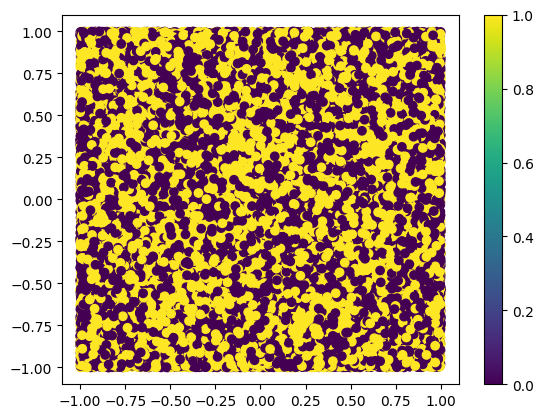

In [10]:
num_data = len(data_x)
num_train= num_data//2
num_vali = num_data//4
num_test = num_data//4
train_data = data_x[:num_train,:]
train_data_labels = labels[:num_train]

vali_data = data_x[num_train:num_train+num_vali,:]
vali_data_labels = labels[num_train:num_train+num_vali]

test_data = data_x[num_train+num_vali :,:]
test_data_labels = labels[num_train+num_vali :]

plt.scatter(data_x[:,0], data_x[:,1], c=labels)
plt.colorbar()

In [11]:
def evaluate_algorithm():
#     # Load the dataset using the provided fetch function
#     data_splits = data_fetch_function()

    # Algorithms to evaluate
    algorithms = [
        ("Logistic Regression", LogisticRegression(max_iter=100)),
        ("SVM", SVC()),
        ("Naive Bayes", GaussianNB()),
        ("K-NN", KNeighborsClassifier()),
        ("Relu Neural Networks", MLPClassifier(activation='relu', hidden_layer_sizes=(100, 50, 25))),
        ("Decision Trees", DecisionTreeClassifier()),
        ("Nearest Centroid", NearestCentroid())
    ]

    results = []

    # Iterate over each algorithm
    for algo_name, algo in algorithms:
        print(f"Running {algo_name}...")

        best_acc = 0.0
        best_params = {}

        # Hyperparameter tuning using GridSearchCV
        if algo_name == "Logistic Regression":
            param_grid = {
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'max_iter': [100,1000]
            }
        elif algo_name == "SVM":
            # Define parameter grid for SVC
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10],
                'degree': [2, 3, 4, 5],
            }
            param_grid = {
                'kernel': ['rbf']
            }
        elif algo_name == "Naive Bayes":
            param_grid = {
                'var_smoothing': [1e-08, 1e-07, 1e-05, 1e-04, 1e-02]
            }
        elif algo_name == "K-NN":
            # Define parameter grid for KNeighborsClassifier
            param_grid = {
                'n_neighbors': [1, 3, 5, 7, 9,15],
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }
        elif algo_name == "Relu Neural Networks":
            # Define parameter grid for MLPClassifier
            param_grid = {
                'hidden_layer_sizes': [(500, 500, 500)],
                'alpha': [ 0.01],
                'max_iter': [500],
            }
        elif algo_name == "Decision Trees":
            # Define parameter grid for DecisionTreeClassifier
            param_grid = {
                'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': [3,4,10],
                'min_samples_split': [2, 5, 10,50],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2']
            }
        elif algo_name == "Nearest Centroid":
            # Define parameter grid for NearestCentroid (distance metric)
            param_grid = {
                'metric': ['euclidean']
            }  
        else:
            # Exclude 'priors' from the parameter grid
            param_grid = {k: v for k, v in algo.get_params().items() if k != 'priors'}

        clf = GridSearchCV(algo, param_grid, cv=2, verbose=1, n_jobs=-1)
        clf.fit(vali_data, vali_data_labels)

        best_acc = clf.best_score_
        best_params = clf.best_params_
        
        # Train the final model on combined training and validation data
        model = algo.set_params(**best_params)
        model.fit(train_data,train_data_labels)

        # Predict on the test set
        y_pred = model.predict(test_data)
        test_acc = accuracy_score(test_data_labels, y_pred)

        # Store the results
        results.append({"Algorithm": algo_name, "Best Val Accuracy": best_acc, "Test Accuracy": test_acc})

    # Create a results DataFrame
    results_df = pd.DataFrame(results)

    # Print the results table
    print("\nResults Table:")
    print(results_df)

# evaluate_algorithm()

**Training a DLGN model**

In [12]:
def train_model_func(DLGN_init=None,train_data_curr=train_data,vali_data_curr=vali_data,test_data_curr=test_data,train_labels_curr=train_data_labels,vali_labels_curr=vali_data_labels,test_labels_curr=test_data_labels,num_epoch=num_epoch,NPF_freeze=False,NPV_freeze=False):
    parameter_mask=dict()
    for name,parameter in DLGN_init.named_parameters():
        if name[:5]=="value_"[:5]:
            if NPV_freeze:
                parameter_mask[name]=torch.zeros_like(parameter) # freezing all value network layers
            else:
                parameter_mask[name]=torch.ones_like(parameter) # Updating all value network layers
        if name[:5]=="gating_"[:5]:
            if NPF_freeze:
                parameter_mask[name]=torch.zeros_like(parameter) # freezing all NPF layers
            else:
                parameter_mask[name]=torch.ones_like(parameter) # Updating all NPF layers
                
    print("train_data_curr inside train_model_func:",train_data_curr.shape)
                
    test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn_synthetic(train_data_curr=train_data_curr,
                                                                                       vali_data_curr=vali_data_curr,
                                                                                       test_data_curr=test_data_curr,
                                                                                       train_labels_curr=train_labels_curr,
                                                                                       vali_labels_curr=vali_labels_curr,
                                                                                       test_labels_curr=test_labels_curr,
                                                                                       DLGN_obj=DLGN_init,
                                                                                       num_epoch=num_epoch,
                                                                                       parameter_mask=parameter_mask)
    return DLGN_obj_final,DLGN_obj_store

In [13]:
def test_error_func(Model_obj,test_data,test_data_labels):
    test_outputs_values, test_outputs_gate_scores =Model_obj(torch.Tensor(test_data))
    test_preds = test_outputs_values[-1]
    test_preds = test_preds.cpu().detach().numpy()
    test_error=np.sum(test_data_labels != (np.sign(test_preds[:,0])+1)//2 )/len(test_data_labels)
    if not test_multiple_model:
        print(np.sum(test_data_labels != (np.sign(test_preds[:,0])+1)//2 ))
        print(len(test_data_labels))
        print("Test Error:",test_error)
        print("===================================================================")
    return test_error

In [14]:
## Convention 0th layer is input layer 1st layer is 1st hidden layer and last layer is output layer
## so 3 hidden layers mean 1 input node + 3 hidden layers + 1 output layer

# NPF_freeze = False #Default False, set True - when freeze the whole NPF
# NPV_freeze = False #Default False, set True - when freeze the whole NPV


print("Num Train = ",len(train_data))
print("Num Vali  = ",len(vali_data))
print("Num Test  = ",len(test_data))
print("Data dim  = ",test_data.shape[1])
print("==========DLGN===========") 

Num Train =  45375
Num Vali  =  22687
Num Test  =  22689
Data dim  =  500
==========DLGN===========


In [15]:
def eval_fun(corrupted,data_loader,model):
    total = 0
    correct = 0
    if corrupted:
        total_corrupted = 0
        correct_corrupted = 0
        total_real = 0
        correct_real = 0
    
    #evaluation
    model.eval()
    with torch.no_grad():
        for images,labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            values,gate_scores = model(images)
            test_preds = values[-1]
            test_preds = test_preds.cpu().detach().numpy()
            total+=labels.numel()
            correct+=np.sum(labels.cpu().detach().numpy()%10 == (np.sign(test_preds[:,0])+1)//2).item()
            #For separate corrupted and real train images
            if corrupted:
                idx_corr=labels.cpu().detach().numpy()>9
                total_corrupted += idx_corr.sum().item()
                correct_corrupted+=np.sum(labels[idx_corr].cpu().detach().numpy()%10 == (np.sign(test_preds[idx_corr,0])+1)//2).item()
                idx_real=labels.cpu().detach().numpy()<=9
                total_real+=idx_real.sum().item()
                correct_real+=np.sum((labels[idx_real].cpu().detach().numpy()%10)==(np.sign(test_preds[idx_real,0])+1)//2).item()
        loss_z_o = (total-correct)/(total)
        if corrupted:
            loss_z_o_corrupted = (total_corrupted-correct_corrupted)/(total_corrupted)
            loss_z_o_real = (total_real-correct_real)/(total_real)
        acc=(correct/total*100)
    if corrupted:
        return acc,loss_z_o,loss_z_o_corrupted,loss_z_o_real
    else:
        return acc,loss_z_o


**Decision Tree Synthetic Multiple model test**

In [16]:
test_multiple_model = False

In [17]:
if test_multiple_model:
    num_levels=3
    seed = 365
    input_dim_store=[10,50,100,500,1000] 
    num_data_store=[50000,100000]
    lr_store = [0.001,0.0002,0.00001]
    num_hidden_nodes_store=[[2,2,2],[20,20,20],[100,100,100],[500,500,500]]
    num_epoch=1026
    NPF_freeze = False #Default False, set True - when freeze the whole NPF
    NPV_freeze = False #Default False, set True - when freeze the whole NPV

    for input_dim in input_dim_store:
        for num_data in num_data_store:
            num_data = num_data
            input_dim=input_dim
            seed_set=seed

            num_levels=num_levels

            ((data_x, labels), (w_list, b_list, vals), stats) = data_gen_decision_tree(
                                            dim=input_dim, seed=seed, num_levels=num_levels,
                                            num_data=num_data)
            w_list_old = np.array(w_list)
            num_data = len(data_x)
            num_train= num_data//2
            num_vali = num_data//4
            num_test = num_data//4
            train_data = data_x[:num_train,:]
            train_data_labels = labels[:num_train]

            vali_data = data_x[num_train:num_train+num_vali,:]
            vali_data_labels = labels[num_train:num_train+num_vali]

            test_data = data_x[num_train+num_vali :,:]
            test_data_labels = labels[num_train+num_vali :]
            print("=========================================================================================")
            print("Num Train = ",len(train_data))
            print("Num Vali  = ",len(vali_data))
            print("Num Test  = ",len(test_data))
            print("Data dim  = ",test_data.shape[1])
            print("==========DLGN===========") 
            for lr in lr_store:
                for num_hidden_nodes in num_hidden_nodes_store:
                    print("=========================================================================================")
                    print("input_dim:",input_dim)
                    print("num_data:",num_data)
                    print("num_levels:",num_levels)
                    print("seed:",seed)
                    print("LR Value:",lr)
                    print("num_hidden_nodes:",num_hidden_nodes)
                    print("=========================================================================================")

                    num_hidden_nodes=num_hidden_nodes
                    lr=lr

                    DLGN_init= DLGN_FC(input_dim=input_dim, output_dim=1, num_hidden_nodes=num_hidden_nodes,beta=beta)

                    DLGN_obj_final,DLGN_obj_store=train_model_func(DLGN_init,train_data,vali_data,test_data,train_data_labels,vali_data_labels,test_data_labels,num_epoch,NPF_freeze,NPV_freeze)
                    test_error_store=[]
                    for DLGN_obj in DLGN_obj_store:
                        test_error=test_error_func(Model_obj=DLGN_obj,test_data=test_data,test_data_labels=test_data_labels)
                        test_error_store.append(test_error)
                    print(test_error_store)
                    del DLGN_init
                    del DLGN_obj_store

**FMNIST Multiple model test**

In [18]:
num_epoch=500

In [19]:
seed = 365
DLGN_init= DLGN_FC(input_dim=input_dim, output_dim=1, num_hidden_nodes=num_hidden_nodes,beta=beta)

DLGN_obj_final,DLGN_obj_store=train_model_func(DLGN_init,train_data,vali_data,test_data,train_data_labels,vali_data_labels,test_data_labels,num_epoch,NPF_freeze,NPV_freeze)
test_error_store=[]
for DLGN_obj in DLGN_obj_store:
    test_error=test_error_func(Model_obj=DLGN_obj,test_data=test_data,test_data_labels=test_data_labels)
    test_error_store.append(test_error)
print(test_error_store)

train_data_curr inside train_model_func: (45375, 500)
train_data_curr inside train_dlgn_synthetic: (45375, 500)


100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


11258
22689
Test Error: 0.49618757988452555
11465
22689
Test Error: 0.5053109436290714
11455
22689
Test Error: 0.5048702014191899
8151
22689
Test Error: 0.359248975274362
7605
22689
Test Error: 0.33518445061483537
7527
22689
Test Error: 0.33174666137776015
7495
22689
Test Error: 0.33033628630613954
7421
22689
Test Error: 0.32707479395301686
7717
22689
Test Error: 0.3401207633655075
6129
22689
Test Error: 0.2701309004363348
4386
22689
Test Error: 0.19330953325399974
2666
22689
Test Error: 0.11750187315439199
2371
22689
Test Error: 0.10449997796288951
2297
22689
Test Error: 0.10123848560976685
2278
22689
Test Error: 0.10040107541099211
2271
22689
Test Error: 0.1000925558640751
2254
22689
Test Error: 0.09934329410727666
2251
22689
Test Error: 0.09921107144431222
2238
22689
Test Error: 0.09863810657146635
2231
22689
Test Error: 0.09832958702454934
2230
22689
Test Error: 0.0982855128035612
2230
22689
Test Error: 0.0982855128035612
2224
22689
Test Error: 0.09802106747763233
[0.49618757988452

**Train Error**

In [20]:
test_error=test_error_func(Model_obj=DLGN_obj_store[-1],test_data=train_data,test_data_labels=train_data_labels)

0
45375
Test Error: 0.0


**Test Error**

In [21]:
test_error=test_error_func(Model_obj=DLGN_obj_final,test_data=test_data,test_data_labels=test_data_labels)

2227
22689
Test Error: 0.09815329014059676


**Data vs prediction scatter plot**

**Node hyperplane clustering and alignment with target function discontinuity**

In [22]:

# w_list = w_list_old
w_list = np.concatenate((w_list_old,-w_list_old),axis=0)

effective_weights, effective_biases = DLGN_obj_store[0].return_gating_functions()
wts_list_init=[]
for layer in range(0,len(effective_weights)):
    wts =  np.array(effective_weights[layer].data.cpu().detach().numpy())
    # wts /= np.sign(wts[:,0])[:,None]
    wts /= np.linalg.norm(wts, axis=1)[:,None]
    wts_list_init.append(wts)
wts_list_init = np.concatenate(wts_list_init)

epoch_index=len(DLGN_obj_store)-1
effective_weights, effective_biases = DLGN_obj_store[epoch_index].return_gating_functions()
print("Epoch="+str(epoch_index))
wts_list=[]
for layer in range(len(effective_weights)):
    wts =  np.array(effective_weights[layer].cpu().data.detach().numpy())
    # wts /= np.sign(wts[:,0])[:,None]
    wts /= np.linalg.norm(wts, axis=1)[:,None]
    wts_list.append(wts)
wts_list = np.concatenate(wts_list)
pd = pairwise_distances(wts_list)
#         eps = pd.mean()/1
eps = .4
print("eps=",eps)
core_samples, dbscan_labels = cluster.dbscan(wts_list, eps=eps, metric='euclidean', min_samples=20)
print("core_samples",core_samples)
print("dbscan_labels",dbscan_labels)

num_clusters = max(dbscan_labels)+1
cluster_centres = []
cluster_no = []
for i in range(num_clusters):
    cluster_centres.append(wts_list[dbscan_labels==i].mean(axis=0))
    cluster_no.append(wts_list[dbscan_labels==i].size)
cluster_centres = np.array(cluster_centres)
print("labels:",np.unique(dbscan_labels))
print("cluster_centres:",cluster_centres.shape)
print("cluster_no:",cluster_no)
print("cluster centre with max data:",cluster_centres[np.argmax(cluster_no)].reshape(1, -1).shape)
# rand_subset_wts_list = wts_list[np.random.choice(len(wts_list), len(wts_list)//8, replace=False)]
print("Shape of decision tree node hyperplanes ", w_list.shape)
print("Shape of all halfspace directions of DLGN", wts_list.shape)
print("Shape of cluster centers of the halfspace DLGN directions ",cluster_centres.shape)
# print("Shape of random subset of halfspace directions of DLGN", rand_subset_wts_list.shape)
pd0 =  pairwise_distances(w_list,wts_list_init)
pd1 =  pairwise_distances(w_list,wts_list)
pd2 = pairwise_distances(w_list,cluster_centres)
pd3 = pairwise_distances(w_list,cluster_centres[np.argmax(cluster_no)].reshape(1, -1))
# pd3 = pairwise_distances(w_list,rand_subset_wts_list)
pd_w_list = pairwise_distances(w_list, w_list)
# print(pd1.shape)
# print(pd2.shape)
# print(pd3.shape)
print("Distance of closest init DLGN halfspace to each labelling func hyperplane \n", pd0.min(axis=1)[:len(w_list_old)])
print(pd0.min(axis=1)[len(w_list_old):])
print("Distance of closest lrnd DLGN halfspace to each labelling func hyperplane \n", pd1.min(axis=1)[:len(w_list_old)])
print(pd1.min(axis=1)[len(w_list_old):])
print("Distance of closest halfspace cluster to each labelling func hyperplane \n", pd2.min(axis=1)[:len(w_list_old)])
print(pd2.min(axis=1)[len(w_list_old):])
print("Distance of closest halfspace cluster with max data to each labelling func hyperplane \n", pd3.min(axis=1)[:len(w_list_old)])
print(pd3.min(axis=1)[len(w_list_old):])

# print("Distance of closest DLGN halfspace (randomly chosen frac) to each labelfunc hyperplane \n", pd3.min(axis=1)[:len(w_list_old)])
# print(pd3.min(axis=1)[len(w_list_old):])
print("Number of halfspaces within distance 0.4 of the Dtree hyperplanes \n", np.sum(pd1<0.4, axis=1)[:len(w_list_old)])
print(np.sum(pd1<0.4, axis=1)[len(w_list_old):])
print("Number of halfspaces within distance 0.3 of the Dtree hyperplanes \n", np.sum(pd1<0.3, axis=1)[:len(w_list_old)])
print(np.sum(pd1<0.3, axis=1)[len(w_list_old):])
print("Number of halfspaces within distance 0.2 of the Dtree hyperplanes \n", np.sum(pd1<0.2, axis=1)[:len(w_list_old)])
print(np.sum(pd1<0.2, axis=1)[len(w_list_old):])

# print(np.sum(pd1<0.3, axis=1)[len(w_list_old):])
print("Dtree hyperplanes distance to closest other hyperplane \n", (pd_w_list+5*np.eye(len(w_list))).min(axis=1))

Epoch=22
eps= 0.4
core_samples [ 946 1003 1005 1020 1023 1024 1025 1028 1037 1038 1039 1066 1067 1078
 1111 1116 1123 1126 1137 1141 1143 1154 1159 1171 1180 1185 1189 1196
 1197 1201 1205 1209 1213 1218 1226 1232 1234 1235 1241 1254 1258 1262
 1280 1283 1287 1291 1292 1296 1312 1318 1323 1333 1336 1337 1341 1343
 1348 1354 1363 1367 1372 1380 1382 1384 1393 1400 1402 1418 1420 1421
 1425 1445 1446 1447 1449 1465 1480 1489 1493 1494 1497 1498]
dbscan_labels [-1 -1 -1 ...  0  0 -1]
labels: [-1  0  1  2]
cluster_centres: (3, 500)
cluster_no: [50000, 13000, 11000]
cluster centre with max data: (1, 500)
Shape of decision tree node hyperplanes  (14, 500)
Shape of all halfspace directions of DLGN (1500, 500)
Shape of cluster centers of the halfspace DLGN directions  (3, 500)
Distance of closest init DLGN halfspace to each labelling func hyperplane 
 [1.3099 1.3005 1.3028 1.3228 1.3229 1.3083 1.3111]
[1.2884 1.3079 1.3034 1.3132 1.2965 1.3187 1.3052]
Distance of closest lrnd DLGN halfspace to

**DLGN Decision Tree**

**Node class**

In [23]:
class Node():
    def __init__(self, feature_vals=None,feature_bias=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_vals = feature_vals
        self.feature_bias = feature_bias
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

**Tree class**

In [24]:
#2. Check the weights' (1500x500) 1st index (0th) if it is -ve make the entire row change sign (multiply by -1) and do experiments. So the 4th coordinate datas will now become 1st coordinate,
#so will get everything in +ve w not -ve w. clustering of centres will happen for only +ve.
def process_array(arr):
    mask = arr[:, 0] < 0
    arr[mask] *= -1
    return arr

In [25]:
def pick_bias(curr_data, W):
    X, Y = curr_data[:, :-1], curr_data[:, -1]
    scores = []
    WX = X @ W.T
    min_wx, max_wx = np.min(WX), np.max(WX)

    print("min_wx:",min_wx)
    print("max_wx:",max_wx)
    b_store = np.arange(min_wx, max_wx, .1)
    for b in b_store:
        score = 0
        condition = np.logical_and(WX + b >= -0.1, WX + b <= 0.1)
        relevant_X = X[condition[:, 0]]
        relevant_Y = Y[condition[:, 0]]
   
        if len(relevant_X) > 0:  # Check if there are relevant data points
            xi = relevant_X
            x_dash = xi - (xi @ W.T + b) / (W @ W.T) * W
            distances = np.linalg.norm(x_dash - relevant_X, axis=1)
            nearest_indices = np.argmin(distances)
            xj = relevant_X[nearest_indices]
            yj = relevant_Y[nearest_indices]

            mismatched = relevant_Y != yj
            score = np.sum(mismatched)

        scores.append(score)
    
    return b_store[np.argmax(scores)]


In [26]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset,eps,min_samples,num_hidden_nodes, curr_depth=0,curr_node=0):
        ''' recursive function to build the tree ''' 
#         if len(dataset)==0: return;
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        print("curr_depth:",curr_depth)
        print("curr_node:",curr_node)
        print("num_samples:",num_samples)
        print("num_features:",num_features)

        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset,eps,min_samples,curr_node,num_hidden_nodes)
            # check if information gain is positive
            print("best_info_gain:",best_split["info_gain"])
            if best_split["info_gain"]>0:
            # recur left
#             num_hidden_nodes=[num_hidden_nodes[0]//2**(curr_depth),num_hidden_nodes[1]//2**(curr_depth),num_hidden_nodes[2]//2**(curr_depth)]
                left_subtree = self.build_tree(best_split["dataset_left"],eps,min_samples,num_hidden_nodes, curr_depth+1,2*curr_node+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"],eps,min_samples,num_hidden_nodes, curr_depth+1,2*curr_node+2)
                # return decision node
                return Node(best_split["feature_vals"], best_split["feature_bias"],
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        print("leaf_value:",leaf_value)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset,eps,min_samples,curr_node,num_hidden_nodes):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}

        w_list = np.concatenate((w_list_old,-w_list_old),axis=0) #DT data node hyperplanes
        X, Y = dataset[:,:-1], dataset[:,-1]
        train_data_dt, vali_data_dt, train_data_labels_dt, vali_data_labels_dt = train_test_split(X, Y, test_size=.1, random_state=41)
        set_npseed(seed)
        set_torchseed(seed)
        ##DLGN clustering of wts
        DLGN_init= DLGN_FC(input_dim=input_dim, output_dim=1, num_hidden_nodes=num_hidden_nodes,beta=beta)
        DLGN_obj_final,DLGN_obj_store=train_model_func(DLGN_init,train_data_dt,vali_data_dt,test_data,train_data_labels_dt,vali_data_labels_dt,test_data_labels,num_epoch,NPF_freeze,NPV_freeze)
#         epoch_index=len(DLGN_obj_store)-1
        effective_weights, effective_biases = DLGN_obj_final.return_gating_functions()
        wts_list=[] #DLGN model effective wts
        for layer in range(len(effective_weights)):
#             if layer!=0:
            wts =  np.array(effective_weights[layer].cpu().data.detach().numpy())
            wts /= np.linalg.norm(wts, axis=1)[:,None]
            wts_list.append(wts)
        wts_list = np.concatenate(wts_list)
        wts_list = process_array(wts_list)
        print("wts_list shape:",wts_list.shape)

        
        ##Brute force cheating way of getting the eps and min_samples that will give me best node hyperplane
        eps_list = eps
        min_samples_list = min_samples
        min_dis = np.inf
        eps_best = 0
        min_samples_best = 0
        label_max_clus_best=0
        for eps in eps_list:
            for min_samples in min_samples_list:
                # Dim 500
                if curr_node==0:
                    eps = 0.2
                    min_samples = 30
                if curr_node==1:
                    eps = 0.2
                    min_samples = 100
                if curr_node==2:
                    eps = 0.2
                    min_samples = 50
                #Dim 19
#                 if curr_node==0:
#                     eps = 0.2
#                     min_samples = 10
#                 if curr_node==1:
#                     eps = 0.2
#                     min_samples = 15
#                 if curr_node==2:
#                     eps = 0.2
#                     min_samples = 30
                core_samples, dbscan_labels = cluster.dbscan(wts_list, eps=eps, metric='euclidean', min_samples=min_samples)
                num_clusters = max(dbscan_labels)+1
                if num_clusters>0:
                    print("eps:",eps,"min_samples:",min_samples)
                    cluster_centres = []
                    cluster_no = []
                    for i in range(num_clusters):
                        cluster_centres.append(wts_list[dbscan_labels==i].mean(axis=0))
                        cluster_no.append(len(wts_list[dbscan_labels==i]))
                    cluster_centres = np.array(cluster_centres)
                    label_max_clus = np.argmax(cluster_no)

                    #choosing the cluster as node which has min distance from hyperplane

                    if cluster_centres.shape[0]!=0:
                        print("cluster_centres_size:",len(cluster_centres))
                        print("DT data hyperplane shape",w_list.shape)
                        pd2 = pairwise_distances(w_list,cluster_centres)
                        print("Pairwise Distance of all halfspace cluster centres to each labelling func hyperplane \n ")
                        print("pd2:",pd2)
                        print("No of wts in each cluster:",cluster_no)
            
      
        ## Use the brute force eps and min_sample
        eps_best = eps
        min_samples_best = min_samples
        
        print("eps_best:",eps_best)
        print("min_samples_best:",min_samples_best)
        print("min_dis:",min_dis)
        
        eps = eps_best
        core_samples, dbscan_labels = cluster.dbscan(wts_list, eps=eps, metric='euclidean', min_samples=min_samples_best)
        
#         if num_clusters>0:
        num_clusters = max(dbscan_labels)+1
        cluster_centres = []
        cluster_no = []
        for i in range(num_clusters):
            cluster_centres.append(wts_list[dbscan_labels==i].mean(axis=0))
            cluster_no.append(len(wts_list[dbscan_labels==i]))
        cluster_centres = np.array(cluster_centres)
        label_max_clus = np.argmax(cluster_no)
        
        feature_vals = cluster_centres[label_max_clus].reshape(1,-1)

        
        
        feature_bias = pick_bias(dataset,feature_vals)
        print("============feature_bias===========:",feature_bias)
        
        print("cluster_no:",cluster_no)
        print("cluster_no[label_max_clus]:",cluster_no[label_max_clus])
        print("label_max_clus:",label_max_clus)

        pd3 = pairwise_distances(w_list,feature_vals)
        
        
        print("Distance of closest halfspace cluster to each labelling func hyperplane \n", pd3.min(axis=1)[:])
     
         # get current split
        dataset_left, dataset_right = self.split(dataset, feature_vals,feature_bias)
        # check if childs are not null
        print("dataset_left:",len(dataset_left))
        print("dataset_right:",len(dataset_right))

        if len(dataset_left)>0 and len(dataset_right)>0:
            y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
            print("no of 0s in left:",np.count_nonzero(left_y == 0))
            print("no of 1s in left:",np.count_nonzero(left_y == 1))
            print("no of 0s in right:",np.count_nonzero(right_y == 0))
            print("no of 1s in right:",np.count_nonzero(right_y == 1))

            # compute information gain
            curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
            print("curr_info_gain:",curr_info_gain)
            # update the best split if needed
            
            best_split["feature_vals"] = feature_vals
            best_split["feature_bias"] = feature_bias
            best_split["dataset_left"] = dataset_left
            best_split["dataset_right"] = dataset_right
            best_split["info_gain"] = curr_info_gain
                                  
        # return best split
        return best_split
    
    def split(self, dataset, feature_vals,feature_bias):
        ''' function to split the data '''
        dataset_left = np.array([row for row in dataset if (row[:-1]@feature_vals.T<0)])
        dataset_right = np.array([row for row in dataset if (row[:-1]@feature_vals.T>=0)])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y,eps,min_samples,num_hidden_nodes):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset,eps,min_samples,num_hidden_nodes)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_vals = tree.feature_vals
        feature_bias = tree.feature_bias
        if x@feature_vals.T<0:#+feature_bias<0:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)


**Train-Test split**

In [27]:
num_epoch=256
X = train_data
print(X.shape)
Y = train_data_labels.reshape(-1,1)
print(Y.shape)

(45375, 500)
(45375, 1)


**Fit the model**

In [28]:
#Dim 500
# eps=[0.2]
# min_samples=[100]
# num_hidden_nodes=[500,500,500]
#Dim 19
eps=[0.2]
min_samples=[40]
num_hidden_nodes=[500,500,500]
classifier = DecisionTreeClassifier(min_samples_split=1, max_depth=2)
classifier.fit(X,Y,eps,min_samples,num_hidden_nodes)

curr_depth: 0
curr_node: 0
num_samples: 45375
num_features: 500
train_data_curr inside train_model_func: (40837, 500)
train_data_curr inside train_dlgn_synthetic: (40837, 500)


100%|██████████| 256/256 [00:50<00:00,  5.04it/s]


wts_list shape: (1500, 500)
eps: 0.2 min_samples: 30
cluster_centres_size: 1
DT data hyperplane shape (14, 500)
Pairwise Distance of all halfspace cluster centres to each labelling func hyperplane 
 
pd2: [[0.1039]
 [1.3559]
 [1.3738]
 [1.3826]
 [1.4174]
 [1.4414]
 [1.4222]
 [1.9905]
 [1.461 ]
 [1.4442]
 [1.4357]
 [1.4014]
 [1.3767]
 [1.3965]]
No of wts in each cluster: [36]
eps_best: 0.2
min_samples_best: 30
min_dis: inf
min_wx: -2.7414601891725052
max_wx: 2.2607154025163547
============feature_bias===========: 0.15853981082749735
cluster_no: [36]
cluster_no[label_max_clus]: 36
label_max_clus: 0
Distance of closest halfspace cluster to each labelling func hyperplane 
 [0.1039 1.3559 1.3738 1.3826 1.4174 1.4414 1.4222 1.9905 1.461  1.4442
 1.4357 1.4014 1.3767 1.3965]
dataset_left: 22779
dataset_right: 22596
no of 0s in left: 11416
no of 1s in left: 11363
no of 0s in right: 11379
no of 1s in right: 11217
curr_info_gain: 2.931427607544279e-06
best_info_gain: 2.931427607544279e-06
curr_d

100%|██████████| 256/256 [00:25<00:00, 10.23it/s]


wts_list shape: (1500, 500)
eps: 0.2 min_samples: 100
cluster_centres_size: 1
DT data hyperplane shape (14, 500)
Pairwise Distance of all halfspace cluster centres to each labelling func hyperplane 
 
pd2: [[1.4464]
 [1.9861]
 [1.3941]
 [1.4207]
 [1.3786]
 [1.3999]
 [1.4581]
 [1.3666]
 [0.1237]
 [1.4199]
 [1.3933]
 [1.435 ]
 [1.4143]
 [1.3542]]
No of wts in each cluster: [141]
eps_best: 0.2
min_samples_best: 100
min_dis: inf
min_wx: -2.039752992346887
max_wx: 2.168409397980131
============feature_bias===========: 0.16024700765311506
cluster_no: [141]
cluster_no[label_max_clus]: 141
label_max_clus: 0
Distance of closest halfspace cluster to each labelling func hyperplane 
 [1.4464 1.9861 1.3941 1.4207 1.3786 1.3999 1.4581 1.3666 0.1237 1.4199
 1.3933 1.435  1.4143 1.3542]
dataset_left: 11069
dataset_right: 11710
no of 0s in left: 5540
no of 1s in left: 5529
no of 0s in right: 5876
no of 1s in right: 5834
curr_info_gain: 8.397333957077535e-07
best_info_gain: 8.397333957077535e-07
curr_de

100%|██████████| 256/256 [00:10<00:00, 24.96it/s]


wts_list shape: (1500, 500)
eps: 0.2 min_samples: 40
cluster_centres_size: 1
DT data hyperplane shape (14, 500)
Pairwise Distance of all halfspace cluster centres to each labelling func hyperplane 
 
pd2: [[1.3827]
 [1.3916]
 [1.4084]
 [1.3998]
 [1.9935]
 [1.4649]
 [1.4615]
 [1.4408]
 [1.4322]
 [1.4158]
 [1.4242]
 [0.118 ]
 [1.3572]
 [1.3608]]
No of wts in each cluster: [476]
eps_best: 0.2
min_samples_best: 40
min_dis: inf
min_wx: -1.9483523048990552
max_wx: 2.1039201540122807
============feature_bias===========: 0.05164769510094658
cluster_no: [476]
cluster_no[label_max_clus]: 476
label_max_clus: 0
Distance of closest halfspace cluster to each labelling func hyperplane 
 [1.3827 1.3916 1.4084 1.3998 1.9935 1.4649 1.4615 1.4408 1.4322 1.4158
 1.4242 0.118  1.3572 1.3608]
dataset_left: 5548
dataset_right: 5521
no of 0s in left: 5453
no of 1s in left: 95
no of 0s in right: 87
no of 1s in right: 5434
curr_info_gain: 0.4676565049712521
best_info_gain: 0.4676565049712521
curr_depth: 3
curr_

100%|██████████| 256/256 [00:11<00:00, 22.86it/s]


wts_list shape: (1500, 500)
eps: 0.2 min_samples: 40
cluster_centres_size: 1
DT data hyperplane shape (14, 500)
Pairwise Distance of all halfspace cluster centres to each labelling func hyperplane 
 
pd2: [[1.4022]
 [1.4325]
 [1.3868]
 [0.1044]
 [1.4194]
 [1.3688]
 [1.4183]
 [1.4243]
 [1.3938]
 [1.4393]
 [1.996 ]
 [1.4071]
 [1.4564]
 [1.4082]]
No of wts in each cluster: [493]
eps_best: 0.2
min_samples_best: 40
min_dis: inf
min_wx: -2.262595833082867
max_wx: 2.135921151012325
============feature_bias===========: 0.03740416691713522
cluster_no: [493]
cluster_no[label_max_clus]: 493
label_max_clus: 0
Distance of closest halfspace cluster to each labelling func hyperplane 
 [1.4022 1.4325 1.3868 0.1044 1.4194 1.3688 1.4183 1.4243 1.3938 1.4393
 1.996  1.4071 1.4564 1.4082]
dataset_left: 5962
dataset_right: 5748
no of 0s in left: 183
no of 1s in left: 5779
no of 0s in right: 5693
no of 1s in right: 55
curr_info_gain: 0.4603937975567062
best_info_gain: 0.4603937975567062
curr_depth: 3
curr_n

100%|██████████| 256/256 [00:24<00:00, 10.42it/s]


wts_list shape: (1500, 500)
eps: 0.2 min_samples: 50
cluster_centres_size: 1
DT data hyperplane shape (14, 500)
Pairwise Distance of all halfspace cluster centres to each labelling func hyperplane 
 
pd2: [[1.4404]
 [1.3775]
 [1.9694]
 [1.4159]
 [1.3883]
 [1.4063]
 [1.3945]
 [1.3499]
 [1.414 ]
 [0.136 ]
 [1.3756]
 [1.4035]
 [1.3855]
 [1.3973]]
No of wts in each cluster: [147]
eps_best: 0.2
min_samples_best: 50
min_dis: inf
min_wx: -2.372823700742622
max_wx: 2.7781975543281714
============feature_bias===========: 0.027176299257380077
cluster_no: [147]
cluster_no[label_max_clus]: 147
label_max_clus: 0
Distance of closest halfspace cluster to each labelling func hyperplane 
 [1.4404 1.3775 1.9694 1.4159 1.3883 1.4063 1.3945 1.3499 1.414  0.136
 1.3756 1.4035 1.3855 1.3973]
dataset_left: 11617
dataset_right: 10979
no of 0s in left: 5818
no of 1s in left: 5799
no of 0s in right: 5561
no of 1s in right: 5418
curr_info_gain: 1.620168245175524e-05
best_info_gain: 1.620168245175524e-05
curr_dep

100%|██████████| 256/256 [00:10<00:00, 24.44it/s]


wts_list shape: (1500, 500)
eps: 0.2 min_samples: 40
cluster_centres_size: 1
DT data hyperplane shape (14, 500)
Pairwise Distance of all halfspace cluster centres to each labelling func hyperplane 
 
pd2: [[1.4039]
 [1.4619]
 [1.4245]
 [1.414 ]
 [1.4673]
 [1.4344]
 [1.9932]
 [1.4208]
 [1.361 ]
 [1.4002]
 [1.4108]
 [1.3552]
 [1.39  ]
 [0.1301]]
No of wts in each cluster: [457]
eps_best: 0.2
min_samples_best: 40
min_dis: inf
min_wx: -2.2668054174170393
max_wx: 2.5600900370650352
============feature_bias===========: 0.033194582582962706
cluster_no: [457]
cluster_no[label_max_clus]: 457
label_max_clus: 0
Distance of closest halfspace cluster to each labelling func hyperplane 
 [1.4039 1.4619 1.4245 1.414  1.4673 1.4344 1.9932 1.4208 1.361  1.4002
 1.4108 1.3552 1.39   0.1301]
dataset_left: 5689
dataset_right: 5928
no of 0s in left: 5530
no of 1s in left: 159
no of 0s in right: 288
no of 1s in right: 5640
curr_info_gain: 0.42621640234731956
best_info_gain: 0.42621640234731956
curr_depth: 3


100%|██████████| 256/256 [00:10<00:00, 24.41it/s]


wts_list shape: (1500, 500)
eps: 0.2 min_samples: 40
cluster_centres_size: 1
DT data hyperplane shape (14, 500)
Pairwise Distance of all halfspace cluster centres to each labelling func hyperplane 
 
pd2: [[1.4481]
 [1.4168]
 [1.4046]
 [1.3734]
 [1.3586]
 [0.1223]
 [1.4032]
 [1.373 ]
 [1.4053]
 [1.4175]
 [1.4477]
 [1.4616]
 [1.9918]
 [1.4189]]
No of wts in each cluster: [426]
eps_best: 0.2
min_samples_best: 40
min_dis: inf
min_wx: -2.1217492966189306
max_wx: 2.2835946118824015
============feature_bias===========: -0.02174929661892877
cluster_no: [426]
cluster_no[label_max_clus]: 426
label_max_clus: 0
Distance of closest halfspace cluster to each labelling func hyperplane 
 [1.4481 1.4168 1.4046 1.3734 1.3586 0.1223 1.4032 1.373  1.4053 1.4175
 1.4477 1.4616 1.9918 1.4189]
dataset_left: 5506
dataset_right: 5473
no of 0s in left: 184
no of 1s in left: 5322
no of 0s in right: 5377
no of 1s in right: 96
curr_info_gain: 0.4503355847144842
best_info_gain: 0.4503355847144842
curr_depth: 3
cur

**Test the model**

In [29]:
Y_pred = classifier.predict(test_data) 
from sklearn.metrics import accuracy_score
accuracy_score(test_data_labels, Y_pred)

0.9419983251796025